In [6]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
import os
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go

In [7]:
collisions_file_str = "collisions_{}_{}.csv"
progress_file_str = "progress_{}_{}.csv"
algorithms = ["e2e","e2e_all","sac","ddpg"]
tracks = ["track_porto","track_barca","racecar_walker"]

In [8]:
collisions_dfs = [] 
progress_dfs = []
original_dfs = []
for i in algorithms:
    for j in tracks:
        collision_path = collisions_file_str.format(i,j)
        progress_path = progress_file_str.format(i,j)
        #print("Algorithm:",i,"| Track:",j)
        print('--------------------------------------------------------')
        df = pd.read_csv(progress_path).iloc[:30].rename(columns=lambda col: col.strip())
        df['algorithm'] = i
        df['track'] = j
        original_dfs.append(df)
        df = df[df.columns[:2]].agg(['mean', 'median','std'])
        df['algorithm'] = i
        df['track'] = j
        print(df)
        if(os.path.exists(collision_path)):
            c_df = pd.read_csv(collision_path).rename(columns=lambda col: col.strip())
            col_count = c_df[c_df["experiment_number"]<=30].shape[0]
            row = [[i,j,col_count]]
            print("Number of Collisions",col_count)
        else:
            row = [[i,j,0]]
            print("Number of Collisions",0)
        row_df = pd.DataFrame(row,columns=['algorithm','track','collision_count'])
        collisions_dfs.append(row_df)
        progress_dfs.append(df)
        print('--------------------------------------------------------')

--------------------------------------------------------
        laps_completed  time_elapsed algorithm        track
mean          2.112351     62.343133       e2e  track_porto
median        2.180334     62.324000       e2e  track_porto
std           0.250643      0.093819       e2e  track_porto
Number of Collisions 0
--------------------------------------------------------
--------------------------------------------------------
        laps_completed  time_elapsed algorithm        track
mean          0.490807     55.037033       e2e  track_barca
median        0.556542     62.305000       e2e  track_barca
std           0.150416     16.548745       e2e  track_barca
Number of Collisions 5
--------------------------------------------------------
--------------------------------------------------------
        laps_completed  time_elapsed algorithm           track
mean          0.457328     17.730167       e2e  racecar_walker
median        0.462877     17.999500       e2e  racecar_walker


In [9]:
collisions = pd.concat(collisions_dfs).reset_index().drop(columns="index")
collisions

,algorithm,track,collision_count
0,e2e,track_porto,0
1,e2e,track_barca,5
2,e2e,racecar_walker,30
3,e2e_all,track_porto,0
4,e2e_all,track_barca,0
5,e2e_all,racecar_walker,0
6,sac,track_porto,0
7,sac,track_barca,30
8,sac,racecar_walker,30
9,ddpg,track_porto,0


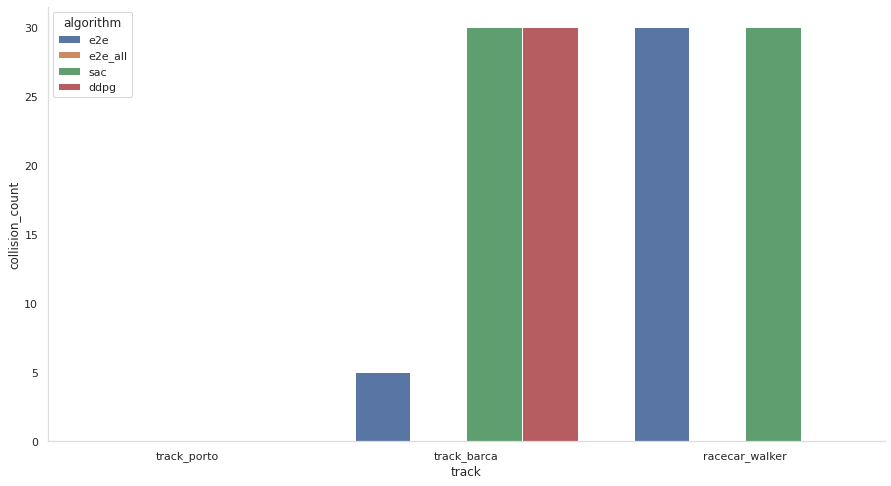

In [10]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data=collisions, x="track",y="collision_count",hue="algorithm")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)

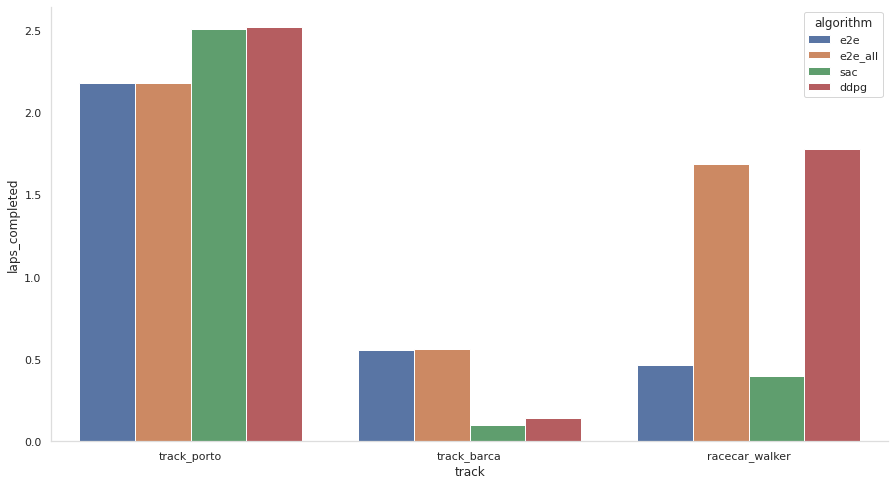

In [11]:
progress = pd.concat(progress_dfs)
plt.figure(figsize=(15,8))
ax = sns.barplot(data=progress[progress.index=='median'], x="track",y="laps_completed",hue="algorithm")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)

In [12]:
all_dfs = pd.concat(original_dfs)
all_dfs

,laps_completed,time_elapsed,experiment_number,algorithm,track
0,2.108580,62.370,1,e2e,track_porto
1,2.181473,62.324,2,e2e,track_porto
2,1.183751,62.324,3,e2e,track_porto
3,2.178436,62.271,4,e2e,track_porto
4,2.183751,62.357,5,e2e,track_porto
...,...,...,...,...,...
25,1.777262,62.325,26,ddpg,racecar_walker
26,1.770302,62.379,27,ddpg,racecar_walker
27,1.771462,62.285,28,ddpg,racecar_walker
28,1.773782,62.357,29,ddpg,racecar_walker


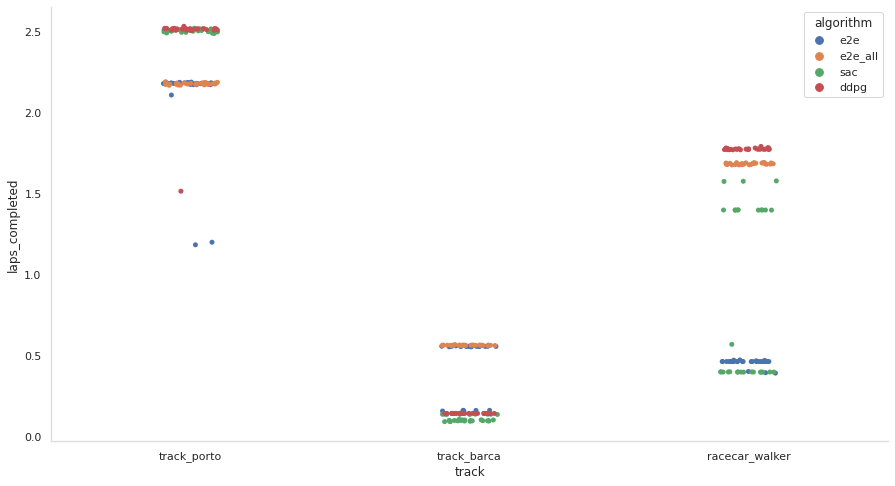

In [13]:
plt.figure(figsize=(15,8))
ax =  sns.stripplot(x="track", y="laps_completed", data=all_dfs,hue='algorithm')
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)

# Analyzing the effect of changing the speed 

In [15]:
ls

AggregrateResultsPatrick.ipynb
collisions_ddpg_racecar_walker_1.5.csv
collisions_ddpg_track_barca_1.5.csv
collisions_ddpg_track_barca.csv
collisions_ddpg_track_porto_1.5.csv
collisions_e2e_all_racecar_walker_1.5.csv
collisions_e2e_all_track_barca_1.5.csv
collisions_e2e_all_track_porto_1.5.csv
collisions_e2e.csv
collisions_e2e_racecar_walker_1.5.csv
collisions_e2e_racecar_walker.csv
collisions_e2e_track_barca_1.5.csv
collisions_e2e_track_barca.csv
collisions_e2e_track_porto_1.5.csv
collisions_sac_racecar_walker_1.5.csv
collisions_sac_racecar_walker.csv
collisions_sac_track_barca_1.5.csv
collisions_sac_track_barca.csv
collisions_sac_track_porto_1.5.csv
collisions.txt
progress_ddpg.csv
progress_ddpg_racecar_walker_1.5.csv
progress_ddpg_racecar_walker.csv
progress_ddpg_track_barca_0.5.csv
progress_ddpg_track_barca_1.5.csv
progress_ddpg_track_barca.csv
progress_ddpg_track_porto_1.5.csv
progress_ddpg_track_porto.csv
progress_e2e_all_racecar_walker_1.5.csv
progress_e2e_all_racecar_walker.csv
